<a href="https://colab.research.google.com/github/trunghq0205/projects/blob/main/Thesis/Stratety_2_sharpe_ratio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Strategy 2: Performance**

# **Load finetuned model**

In [ ]:
!gdown 1KawsXQNvBB9F7onqFaAMShX1FH9fnR6U
!unzip ./uni2ts.zip

Downloading...
From (original): https://drive.google.com/uc?id=1KawsXQNvBB9F7onqFaAMShX1FH9fnR6U
From (redirected): https://drive.google.com/uc?id=1KawsXQNvBB9F7onqFaAMShX1FH9fnR6U&confirm=t&uuid=2e4c17d6-2945-47c9-b9f7-06c99f23eb4a
To: /content/uni2ts.zip
100% 342M/342M [00:12<00:00, 26.3MB/s]
Archive:  ./uni2ts.zip
   creating: uni2ts/
   creating: uni2ts/.git/
   creating: uni2ts/.github/
   creating: uni2ts/cli/
   creating: uni2ts/dataset/
   creating: uni2ts/example/
   creating: uni2ts/finetune/
   creating: uni2ts/outputs/
   creating: uni2ts/project/
   creating: uni2ts/src/
   creating: uni2ts/test/
  inflating: uni2ts/CODEOWNERS       
  inflating: uni2ts/forecast.pkl     
  inflating: uni2ts/CODE_OF_CONDUCT.md  
  inflating: uni2ts/SECURITY.md      
  inflating: uni2ts/CITATION.cff     
  inflating: uni2ts/CONTRIBUTING.md  
  inflating: uni2ts/.pre-commit-config.yaml  
  inflating: uni2ts/pyproject.toml   
  inflating: uni2ts/README.md        
  inflating: uni2ts/.gitignore

In [ ]:
cd uni2ts

/content/uni2ts


In [ ]:
!pip install -e '.[notebook]'

Obtaining file:///content/uni2ts
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-

In [ ]:
cd uni2ts

/content/uni2ts


In [ ]:
%env CUSTOM_DATA_PATH=./finetune

env: CUSTOM_DATA_PATH=./finetune


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


import numpy as np
import pickle
import gdown
import datasets

## **Split data**

In [ ]:
data = pd.read_csv('dataset/VN30/VN30_2018_2019.csv')
data = data.tail(250)

In [ ]:
# Chia DataFrame thành 5 bộ data, mỗi bộ bao gồm 50 ngày
split_data = [data.iloc[i:i + 50] for i in range(0, len(data), 50)]

# Lưu từng bộ data vào các file CSV riêng biệt
for i, df in enumerate(split_data):
    filename = f'data_part_{i+1}.csv'
    df.to_csv(filename, index=False)
    print(f'Data part {i+1} saved to {filename}')

Data part 1 saved to data_part_1.csv
Data part 2 saved to data_part_2.csv
Data part 3 saved to data_part_3.csv
Data part 4 saved to data_part_4.csv
Data part 5 saved to data_part_5.csv


## **Return Calculating**

In [ ]:
# Moving Average Crossover
def moving_average_crossover(data, short_window=7, long_window=14):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['VN30']
    signals['short_mavg'] = data['VN30'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data['VN30'].rolling(window=long_window, min_periods=1).mean()

    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()

    return signals

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_forecast(forecast, labels, change_num):

    # Tính đường median
    median = np.median(forecast, axis=0)

    # Tính các khoảng tin cậy
    ci90_lower = np.percentile(forecast, 5, axis=0)
    ci90_upper = np.percentile(forecast, 95, axis=0)
    ci70_lower = np.percentile(forecast, 15, axis=0)
    ci70_upper = np.percentile(forecast, 85, axis=0)

    # Tính MAE cho từng ngày
    mae_per_day = np.mean(np.abs(labels - forecast), axis=0)
    print("MAE per day:\n", mae_per_day)

    # Lấy ra top 10 ngày có MAE lớn nhất
    top_10_days = np.argsort(mae_per_day)[-change_num:][::-1]

    # Vẽ biểu đồ
    days = np.arange(1, forecast.shape[1] + 1)
    plt.figure(figsize=(14, 7))

    plt.plot(days, median, label='Prediction (Median)', linestyle='--', color='blue')

    plt.fill_between(days, ci90_lower, ci90_upper, color='#ccccff', label='90% Confidence Interval')
    plt.fill_between(days, ci70_lower, ci70_upper, color='#9999ee', label='70% Confidence Interval')

    # Vẽ đường labels
    plt.plot(days, labels, label='Target', color='black')

    # Đánh dấu top 10 ngày có MAE lớn nhất trên đường labels với style vòng tròn có viền màu đỏ, không cần fill màu
    plt.plot(top_10_days + 1, labels[top_10_days], 'o', markerfacecolor='none', markeredgecolor='red', markersize=8, label='Change-point')

    # Hiển thị nhãn cho top 10 ngày trên đường labels
    temp = []
    for day in top_10_days:
        plt.text(day + 1, labels[day], f'{day + 1}', fontsize=10, ha='center', va='bottom')
        if labels[day] < ci90_lower[day] or labels[day] > ci90_upper[day]:
            print(f'Ngày {day + 1} nằm ngoài khoảng tin cậy 90%')
            temp.append(day + 1)

    plt.xlabel('Time')
    plt.ylabel('Forecast Value')
    plt.title('Top 25 Change-points')

    plt.legend()
    plt.show()

    return mae_per_day, top_10_days, temp

## **Data 1**

**Moving average**

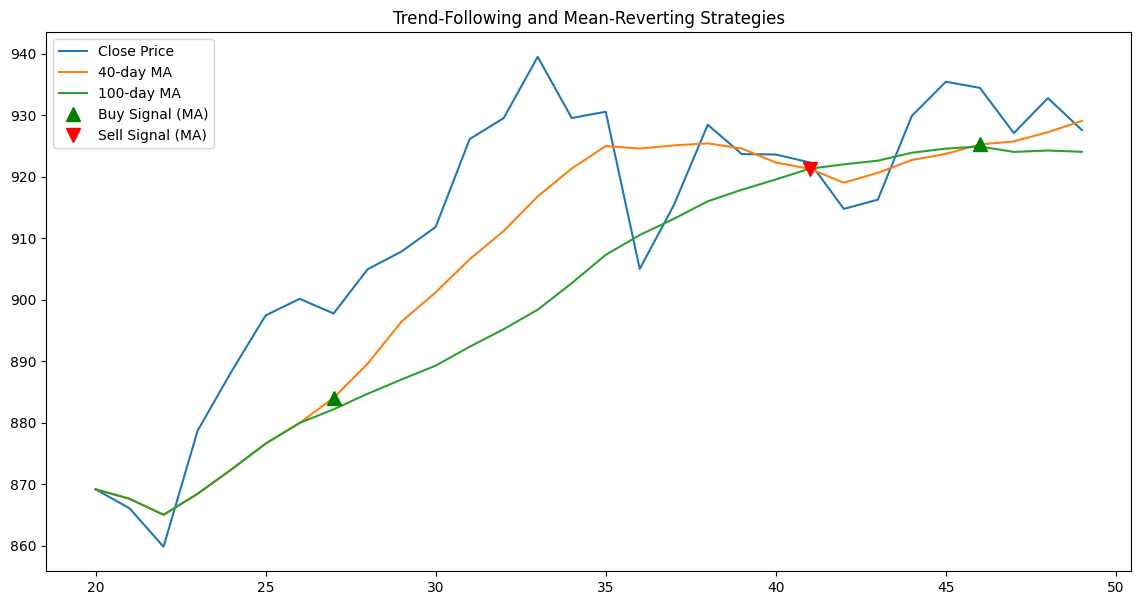

In [ ]:
df1 = pd.read_csv("data_part_1.csv")
df1 = df1.tail(30)

# Generate signals
mac_signals = moving_average_crossover(df1)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df1['VN30'], label='Close Price')
plt.plot(mac_signals['short_mavg'], label='40-day MA')
plt.plot(mac_signals['long_mavg'], label='100-day MA')

# Plot buy and sell signals
plt.plot(mac_signals.loc[mac_signals.positions == 1.0].index,
         mac_signals.short_mavg[mac_signals.positions == 1.0],
         '^', markersize=10, color='g', lw=0, label='Buy Signal (MA)')
plt.plot(mac_signals.loc[mac_signals.positions == -1.0].index,
         mac_signals.short_mavg[mac_signals.positions == -1.0],
         'v', markersize=10, color='r', lw=0, label='Sell Signal (MA)')


plt.title('Trend-Following and Mean-Reverting Strategies')
plt.legend()
plt.show()

In [ ]:
mac_signals.to_csv("result1.csv")

**Change-point**

/content/uni2ts/src/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")
Saving the dataset (1/1 shards): 100% 1/1 [00:00<00:00, 146.85 examples/s]
2024-07-15 10:31:44.748389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 10:31:44.748458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 10:31:44.750693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 10:31:44.762492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in perform

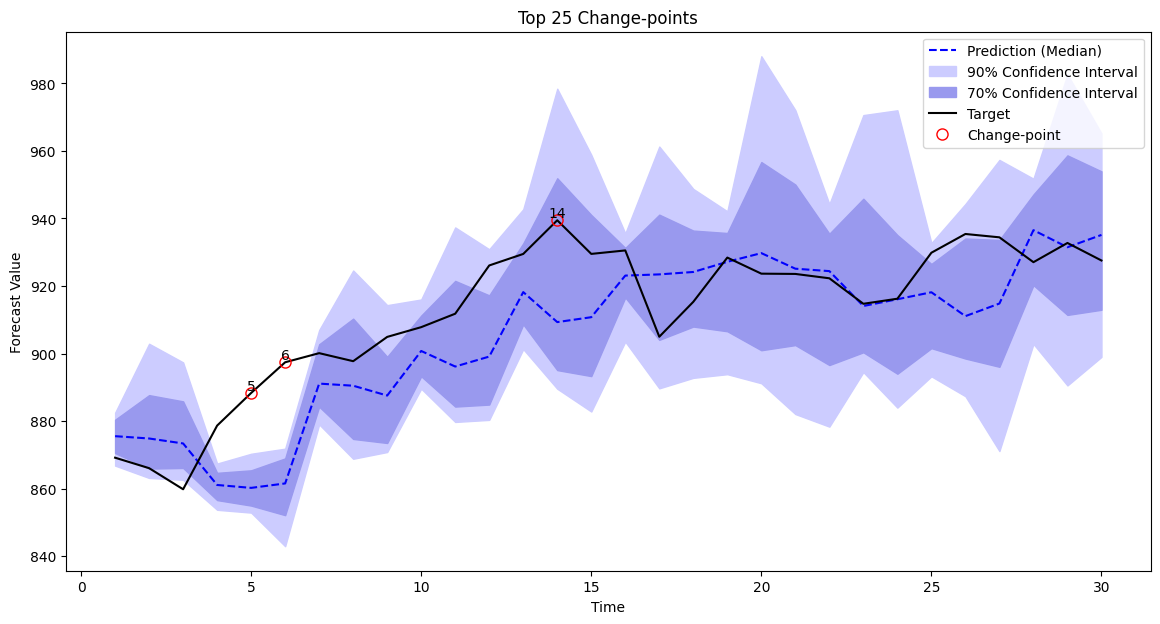

In [ ]:
!python -m uni2ts.data.builder.simple VN30_test data_part_1.csv --dataset_type wide_multivariate

# 1
!python -m cli.eval run_name=base_eval_1407 model=moirai_1.0_R_base model.patch_size=16 model.context_length=400 data=vn30_test


with open("forecast.pkl", "rb") as f:
    forecast = pickle.load(f)


with open("forecast.pkl", "rb") as f:
    forecast = pickle.load(f)

temp1 = None
forecasts = forecast[0]
for i in range(9):
  temp1 = forecast[i+1]
  forecasts = np.hstack((forecasts, temp1))

with open("label.pkl", "rb") as f:
    label = pickle.load(f)

temp2 = None
labels = label[0]
for i in range(9):
  temp2 = label[i+1]
  labels = np.hstack((labels, temp2))

labels = labels.reshape(30, )

mae_forecasts = forecasts
mae_labels = labels

mae_per_day, top_10_days, temp = plot_forecast(mae_forecasts, mae_labels, change_num = 3)

**Sharpe ratio**

In [ ]:
res1 = pd.read_csv("./results/MA_CP1.csv")
res1

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP
0,20,869.16,869.160000,869.160000,0,NaN,NaN,NaN
1,21,866.06,867.610000,867.610000,0,0.0,0.000000,0.000000
2,22,859.81,865.010000,865.010000,0,0.0,0.000000,0.000000
3,23,878.67,868.425000,868.425000,0,0.0,0.000000,0.000000
4,24,888.33,872.406000,872.406000,0,0.0,0.000000,0.000000
5,25,897.42,876.575000,876.575000,0,0.0,0.000000,0.000000
6,26,900.12,879.938571,879.938571,0,0.0,0.000000,0.000000
7,27,897.74,884.021429,882.163750,1,1.0,0.000000,0.000000
8,28,904.93,889.574286,884.693333,1,0.0,0.000000,0.000000
9,29,907.82,896.432857,887.006000,1,0.0,0.000000,0.000000


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res1['MA'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: 2.8237718108242817


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res1['CP'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: 2.8748426011028454


In [ ]:
# Calculate cumulative returns
res1['Cumulative MA'] = (1 + res1['MA']).cumprod() - 1
res1['Cumulative CP'] = (1 + res1['CP']).cumprod() - 1

In [ ]:
res1

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP,Cumulative MA,Cumulative CP
0,20,869.16,869.160000,869.160000,0,NaN,NaN,NaN,NaN,NaN
1,21,866.06,867.610000,867.610000,0,0.0,0.000000,0.000000,0.000000,0.000000
2,22,859.81,865.010000,865.010000,0,0.0,0.000000,0.000000,0.000000,0.000000
3,23,878.67,868.425000,868.425000,0,0.0,0.000000,0.000000,0.000000,0.000000
4,24,888.33,872.406000,872.406000,0,0.0,0.000000,0.000000,0.000000,0.000000
5,25,897.42,876.575000,876.575000,0,0.0,0.000000,0.000000,0.000000,0.000000
6,26,900.12,879.938571,879.938571,0,0.0,0.000000,0.000000,0.000000,0.000000
7,27,897.74,884.021429,882.163750,1,1.0,0.000000,0.000000,0.000000,0.000000
8,28,904.93,889.574286,884.693333,1,0.0,0.000000,0.000000,0.000000,0.000000
9,29,907.82,896.432857,887.006000,1,0.0,0.000000,0.000000,0.000000,0.000000


## **Data 2**

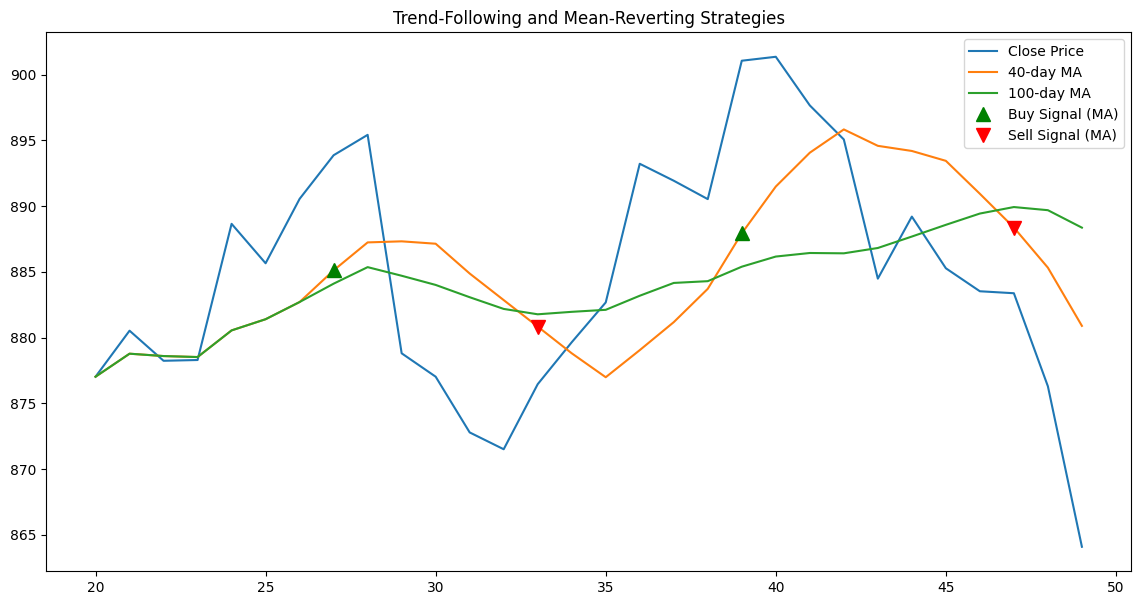

In [ ]:
df1 = pd.read_csv("data_part_2.csv")
df1 = df1.tail(30)

# Generate signals
mac_signals = moving_average_crossover(df1)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df1['VN30'], label='Close Price')
plt.plot(mac_signals['short_mavg'], label='40-day MA')
plt.plot(mac_signals['long_mavg'], label='100-day MA')

# Plot buy and sell signals
plt.plot(mac_signals.loc[mac_signals.positions == 1.0].index,
         mac_signals.short_mavg[mac_signals.positions == 1.0],
         '^', markersize=10, color='g', lw=0, label='Buy Signal (MA)')
plt.plot(mac_signals.loc[mac_signals.positions == -1.0].index,
         mac_signals.short_mavg[mac_signals.positions == -1.0],
         'v', markersize=10, color='r', lw=0, label='Sell Signal (MA)')


plt.title('Trend-Following and Mean-Reverting Strategies')
plt.legend()
plt.show()

In [ ]:
mac_signals.to_csv("result2.csv")

**Change-point**

/content/uni2ts/src/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")
Saving the dataset (1/1 shards): 100% 1/1 [00:00<00:00, 109.92 examples/s]
2024-07-15 09:56:32.418895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 09:56:32.418947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 09:56:32.420556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 09:56:32.428039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in perform

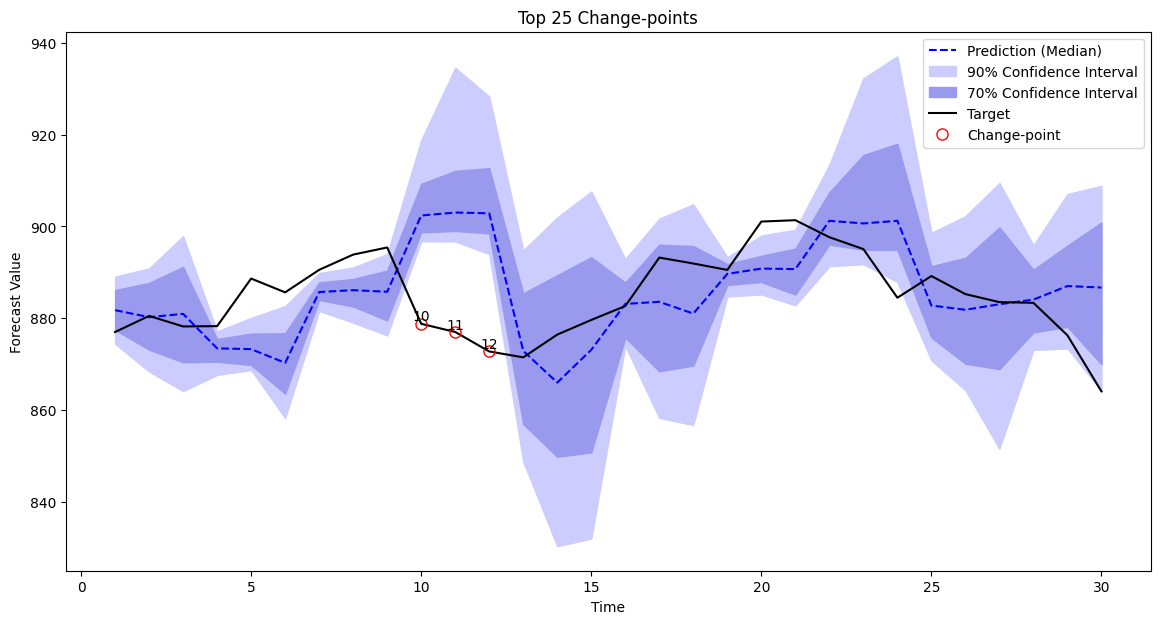

In [ ]:
!python -m uni2ts.data.builder.simple VN30_test data_part_2.csv --dataset_type wide_multivariate

# 1
!python -m cli.eval run_name=base_eval_1407 model=moirai_1.0_R_base model.patch_size=16 model.context_length=200 data=vn30_test


with open("forecast.pkl", "rb") as f:
    forecast = pickle.load(f)


with open("forecast.pkl", "rb") as f:
    forecast = pickle.load(f)

temp1 = None
forecasts = forecast[0]
for i in range(9):
  temp1 = forecast[i+1]
  forecasts = np.hstack((forecasts, temp1))

with open("label.pkl", "rb") as f:
    label = pickle.load(f)

temp2 = None
labels = label[0]
for i in range(9):
  temp2 = label[i+1]
  labels = np.hstack((labels, temp2))

labels = labels.reshape(30, )

mae_forecasts = forecasts
mae_labels = labels

mae_per_day, top_10_days, temp = plot_forecast(mae_forecasts, mae_labels, change_num = 3)

**Sharpe Ratio**

In [ ]:
res2 = pd.read_csv("./results/MA_CP2.csv")
res2

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP
0,20,877.02,877.020000,877.020000,0,NaN,NaN,NaN
1,21,880.52,878.770000,878.770000,0,0.0,0.000000,0.000000
2,22,878.23,878.590000,878.590000,0,0.0,0.000000,0.000000
3,23,878.29,878.515000,878.515000,0,0.0,0.000000,0.000000
4,24,888.65,880.542000,880.542000,0,0.0,0.000000,0.000000
5,25,885.65,881.393333,881.393333,0,0.0,0.000000,0.000000
6,26,890.55,882.701429,882.701429,0,0.0,0.000000,0.000000
7,27,893.87,885.108571,884.097500,1,1.0,0.000000,0.000000
8,28,895.42,887.237143,885.355556,1,0.0,0.000000,0.000000
9,29,878.80,887.318571,884.700000,1,0.0,0.000000,-0.016859


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res2['MA'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: -4.370200367298516


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res2['CP'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: -3.1490368661149146


In [ ]:
# Calculate cumulative returns
res2['Cumulative MA'] = (1 + res2['MA']).cumprod() - 1
res2['Cumulative CP'] = (1 + res2['CP']).cumprod() - 1

In [ ]:
res2

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP,Cumulative MA,Cumulative CP
0,20,877.02,877.020000,877.020000,0,NaN,NaN,NaN,NaN,NaN
1,21,880.52,878.770000,878.770000,0,0.0,0.000000,0.000000,0.000000,0.000000
2,22,878.23,878.590000,878.590000,0,0.0,0.000000,0.000000,0.000000,0.000000
3,23,878.29,878.515000,878.515000,0,0.0,0.000000,0.000000,0.000000,0.000000
4,24,888.65,880.542000,880.542000,0,0.0,0.000000,0.000000,0.000000,0.000000
5,25,885.65,881.393333,881.393333,0,0.0,0.000000,0.000000,0.000000,0.000000
6,26,890.55,882.701429,882.701429,0,0.0,0.000000,0.000000,0.000000,0.000000
7,27,893.87,885.108571,884.097500,1,1.0,0.000000,0.000000,0.000000,0.000000
8,28,895.42,887.237143,885.355556,1,0.0,0.000000,0.000000,0.000000,0.000000
9,29,878.80,887.318571,884.700000,1,0.0,0.000000,-0.016859,0.000000,-0.016859


## **Data 3**

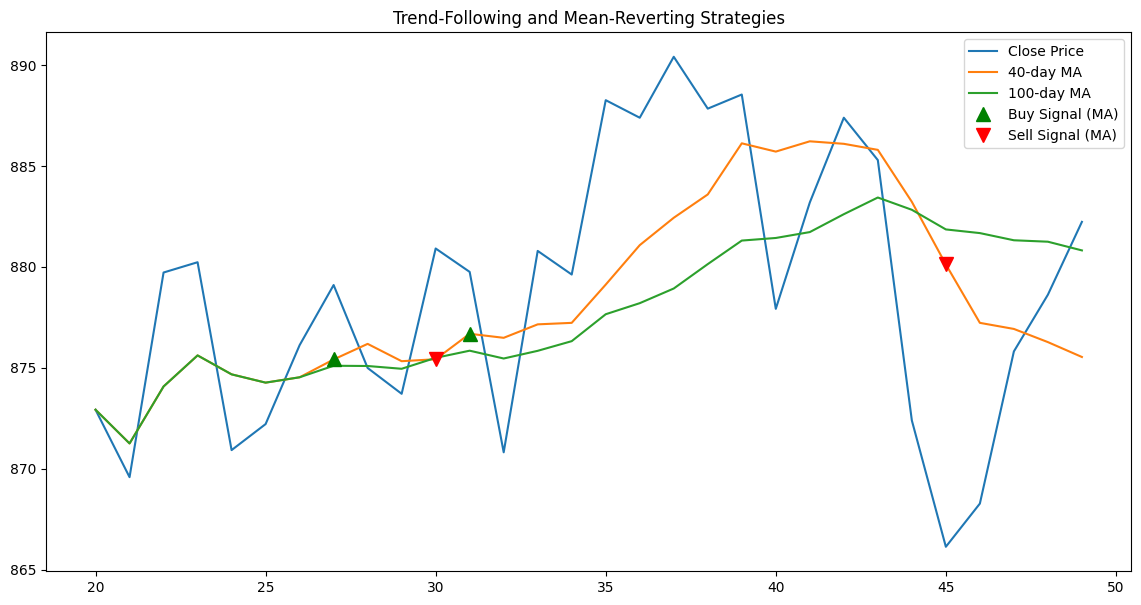

In [ ]:
df1 = pd.read_csv("data_part_3.csv")
df1 = df1.tail(30)

# Generate signals
mac_signals = moving_average_crossover(df1)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df1['VN30'], label='Close Price')
plt.plot(mac_signals['short_mavg'], label='40-day MA')
plt.plot(mac_signals['long_mavg'], label='100-day MA')

# Plot buy and sell signals
plt.plot(mac_signals.loc[mac_signals.positions == 1.0].index,
         mac_signals.short_mavg[mac_signals.positions == 1.0],
         '^', markersize=10, color='g', lw=0, label='Buy Signal (MA)')
plt.plot(mac_signals.loc[mac_signals.positions == -1.0].index,
         mac_signals.short_mavg[mac_signals.positions == -1.0],
         'v', markersize=10, color='r', lw=0, label='Sell Signal (MA)')


plt.title('Trend-Following and Mean-Reverting Strategies')
plt.legend()
plt.show()

In [ ]:
mac_signals.to_csv("result3.csv")

**Change-point**

/content/uni2ts/src/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")
Saving the dataset (1/1 shards): 100% 1/1 [00:00<00:00, 153.41 examples/s]
2024-07-15 10:11:01.457496: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 10:11:01.457547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 10:11:01.458896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 10:11:01.465699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in perform

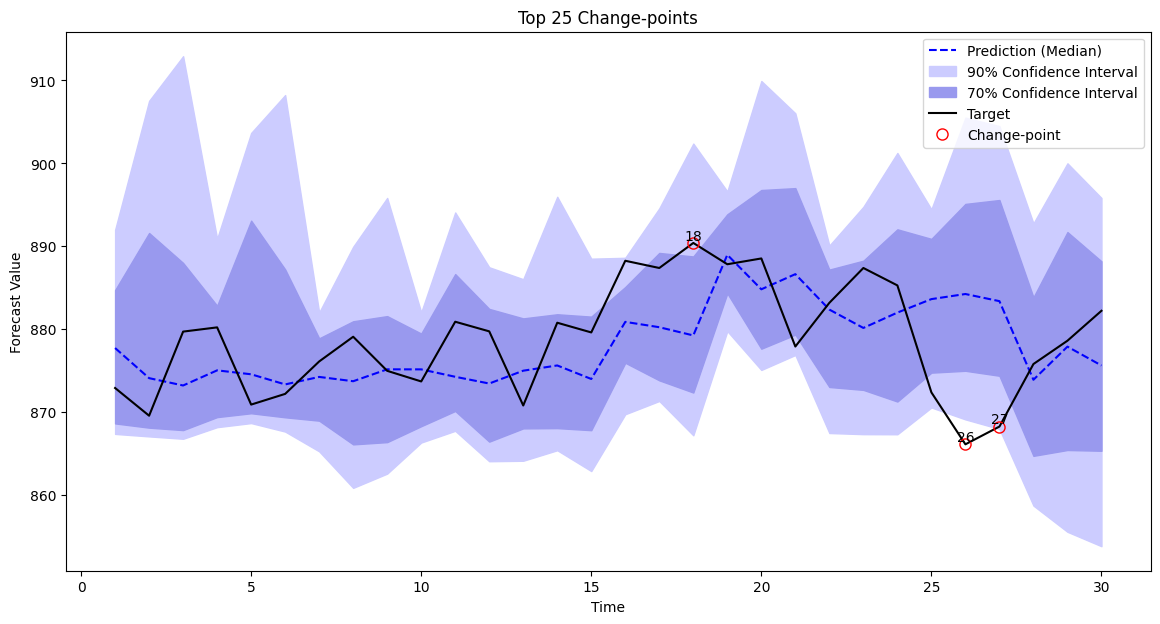

In [ ]:
!python -m uni2ts.data.builder.simple VN30_test data_part_3.csv --dataset_type wide_multivariate

# 1
!python -m cli.eval run_name=base_eval_1407 model=moirai_1.0_R_base model.patch_size=16 model.context_length=200 data=vn30_test


with open("forecast.pkl", "rb") as f:
    forecast = pickle.load(f)


with open("forecast.pkl", "rb") as f:
    forecast = pickle.load(f)

temp1 = None
forecasts = forecast[0]
for i in range(9):
  temp1 = forecast[i+1]
  forecasts = np.hstack((forecasts, temp1))

with open("label.pkl", "rb") as f:
    label = pickle.load(f)

temp2 = None
labels = label[0]
for i in range(9):
  temp2 = label[i+1]
  labels = np.hstack((labels, temp2))

labels = labels.reshape(30, )

mae_forecasts = forecasts
mae_labels = labels

mae_per_day, top_10_days, temp = plot_forecast(mae_forecasts, mae_labels, change_num = 3)

**Sharpe Ratio**

In [ ]:
res3 = pd.read_csv("./results/MA_CP3.csv")
res3

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP
0,20,872.92,872.920000,872.920000,0,NaN,NaN,NaN
1,21,869.58,871.250000,871.250000,0,0.0,0.000000,0.000000
2,22,879.72,874.073333,874.073333,0,0.0,0.000000,0.000000
3,23,880.23,875.612500,875.612500,0,0.0,0.000000,0.000000
4,24,870.92,874.674000,874.674000,0,0.0,0.000000,0.000000
5,25,872.21,874.263333,874.263333,0,0.0,0.000000,0.000000
6,26,876.12,874.528571,874.528571,0,0.0,0.000000,0.000000
7,27,879.10,875.411429,875.100000,1,1.0,0.000000,0.000000
8,28,874.99,876.184286,875.087778,1,0.0,0.000000,0.000000
9,29,873.71,875.325714,874.950000,1,0.0,0.000000,0.000000


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res3['MA'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: -2.7379402799427157


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res3['CP'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: 3.142563509265946


In [ ]:
# Calculate cumulative returns
res3['Cumulative MA'] = (1 + res3['MA']).cumprod() - 1
res3['Cumulative CP'] = (1 + res3['CP']).cumprod() - 1
res3

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP,Cumulative MA,Cumulative CP
0,20,872.92,872.920000,872.920000,0,NaN,NaN,NaN,NaN,NaN
1,21,869.58,871.250000,871.250000,0,0.0,0.000000,0.000000,0.000000,0.000000
2,22,879.72,874.073333,874.073333,0,0.0,0.000000,0.000000,0.000000,0.000000
3,23,880.23,875.612500,875.612500,0,0.0,0.000000,0.000000,0.000000,0.000000
4,24,870.92,874.674000,874.674000,0,0.0,0.000000,0.000000,0.000000,0.000000
5,25,872.21,874.263333,874.263333,0,0.0,0.000000,0.000000,0.000000,0.000000
6,26,876.12,874.528571,874.528571,0,0.0,0.000000,0.000000,0.000000,0.000000
7,27,879.10,875.411429,875.100000,1,1.0,0.000000,0.000000,0.000000,0.000000
8,28,874.99,876.184286,875.087778,1,0.0,0.000000,0.000000,0.000000,0.000000
9,29,873.71,875.325714,874.950000,1,0.0,0.000000,0.000000,0.000000,0.000000


## **Data 4**

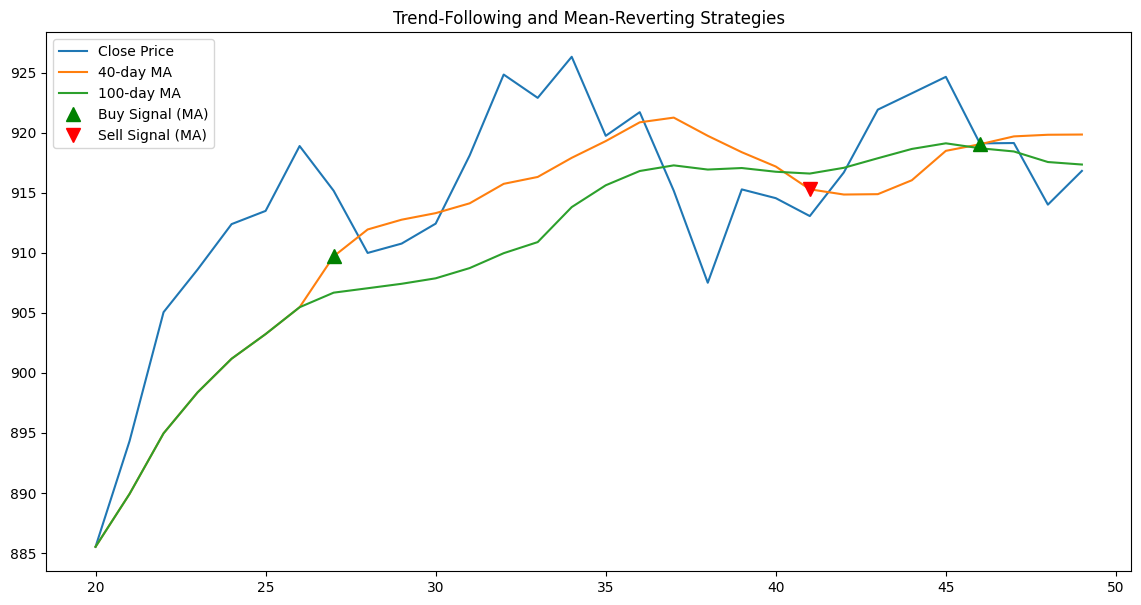

In [ ]:
df1 = pd.read_csv("data_part_4.csv")
df1 = df1.tail(30)

# Generate signals
mac_signals = moving_average_crossover(df1)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df1['VN30'], label='Close Price')
plt.plot(mac_signals['short_mavg'], label='40-day MA')
plt.plot(mac_signals['long_mavg'], label='100-day MA')

# Plot buy and sell signals
plt.plot(mac_signals.loc[mac_signals.positions == 1.0].index,
         mac_signals.short_mavg[mac_signals.positions == 1.0],
         '^', markersize=10, color='g', lw=0, label='Buy Signal (MA)')
plt.plot(mac_signals.loc[mac_signals.positions == -1.0].index,
         mac_signals.short_mavg[mac_signals.positions == -1.0],
         'v', markersize=10, color='r', lw=0, label='Sell Signal (MA)')


plt.title('Trend-Following and Mean-Reverting Strategies')
plt.legend()
plt.show()

In [ ]:
mac_signals.to_csv("result4.csv")

**Change-point**

/content/uni2ts/src/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")
Saving the dataset (1/1 shards): 100% 1/1 [00:00<00:00, 156.02 examples/s]
2024-07-15 10:25:24.374775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 10:25:24.374836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 10:25:24.376142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 10:25:24.383551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in perform

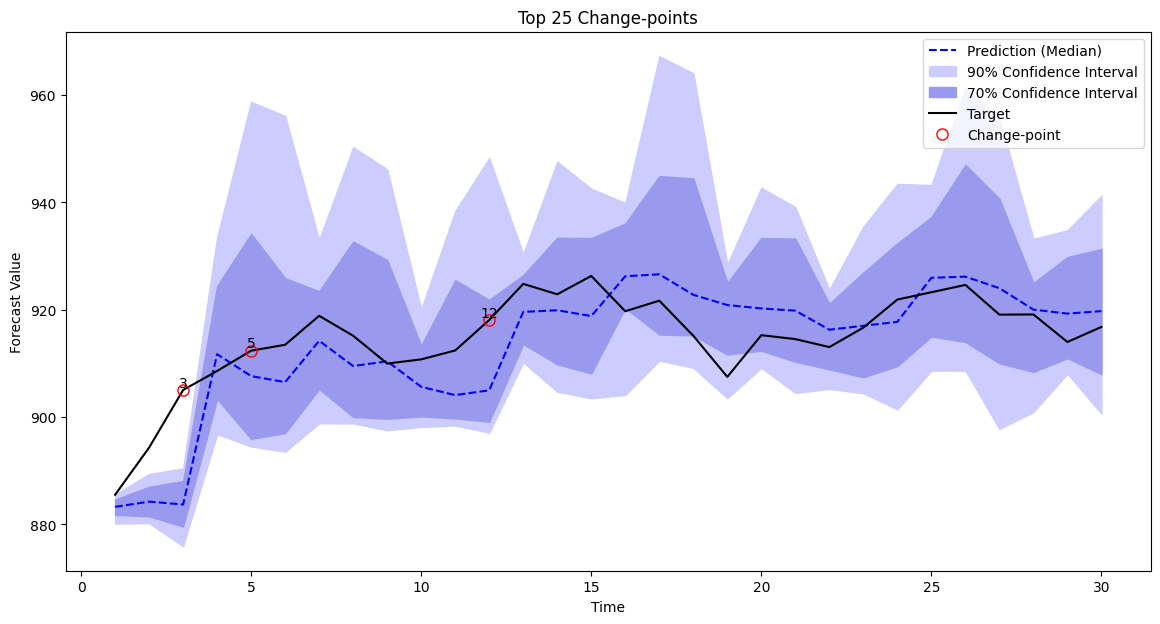

In [ ]:
!python -m uni2ts.data.builder.simple VN30_test data_part_4.csv --dataset_type wide_multivariate

# 1
!python -m cli.eval run_name=base_eval_1407 model=moirai_1.0_R_base model.patch_size=16 model.context_length=200 data=vn30_test


with open("forecast.pkl", "rb") as f:
    forecast = pickle.load(f)


with open("forecast.pkl", "rb") as f:
    forecast = pickle.load(f)

temp1 = None
forecasts = forecast[0]
for i in range(9):
  temp1 = forecast[i+1]
  forecasts = np.hstack((forecasts, temp1))

with open("label.pkl", "rb") as f:
    label = pickle.load(f)

temp2 = None
labels = label[0]
for i in range(9):
  temp2 = label[i+1]
  labels = np.hstack((labels, temp2))

labels = labels.reshape(30, )

mae_forecasts = forecasts
mae_labels = labels

mae_per_day, top_10_days, temp = plot_forecast(mae_forecasts, mae_labels, change_num = 3)

**Sharpe Ratio**

In [ ]:
res4 = pd.read_csv("./results/MA_CP4.csv")
res4

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP
0,20,885.52,885.520000,885.520000,0,NaN,NaN,NaN
1,21,894.32,889.920000,889.920000,0,0.0,0.000000,0.000000
2,22,905.05,894.963333,894.963333,0,0.0,0.000000,0.000000
3,23,908.60,898.372500,898.372500,0,0.0,0.000000,0.000000
4,24,912.38,901.174000,901.174000,0,0.0,0.000000,0.000000
5,25,913.48,903.225000,903.225000,0,0.0,0.000000,0.000000
6,26,918.88,905.461429,905.461429,0,0.0,0.000000,0.000000
7,27,915.16,909.695714,906.673750,1,1.0,0.000000,0.000000
8,28,909.98,911.932857,907.041111,1,0.0,0.000000,0.000000
9,29,910.76,912.748571,907.413000,1,0.0,0.000000,0.000000


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res4['MA'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: -4.419162839323615


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res4['CP'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: 1.8918597726383282


In [ ]:
# Calculate cumulative returns
res4['Cumulative MA'] = (1 + res4['MA']).cumprod() - 1
res4['Cumulative CP'] = (1 + res4['CP']).cumprod() - 1
res4

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP,Cumulative MA,Cumulative CP
0,20,885.52,885.520000,885.520000,0,NaN,NaN,NaN,NaN,NaN
1,21,894.32,889.920000,889.920000,0,0.0,0.000000,0.000000,0.000000,0.000000
2,22,905.05,894.963333,894.963333,0,0.0,0.000000,0.000000,0.000000,0.000000
3,23,908.60,898.372500,898.372500,0,0.0,0.000000,0.000000,0.000000,0.000000
4,24,912.38,901.174000,901.174000,0,0.0,0.000000,0.000000,0.000000,0.000000
5,25,913.48,903.225000,903.225000,0,0.0,0.000000,0.000000,0.000000,0.000000
6,26,918.88,905.461429,905.461429,0,0.0,0.000000,0.000000,0.000000,0.000000
7,27,915.16,909.695714,906.673750,1,1.0,0.000000,0.000000,0.000000,0.000000
8,28,909.98,911.932857,907.041111,1,0.0,0.000000,0.000000,0.000000,0.000000
9,29,910.76,912.748571,907.413000,1,0.0,0.000000,0.000000,0.000000,0.000000


## **Data 5**

In [ ]:
# Moving Average Crossover
def moving_average_crossover(data, short_window=5, long_window=10):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['VN30']
    signals['short_mavg'] = data['VN30'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data['VN30'].rolling(window=long_window, min_periods=1).mean()

    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()

    return signals

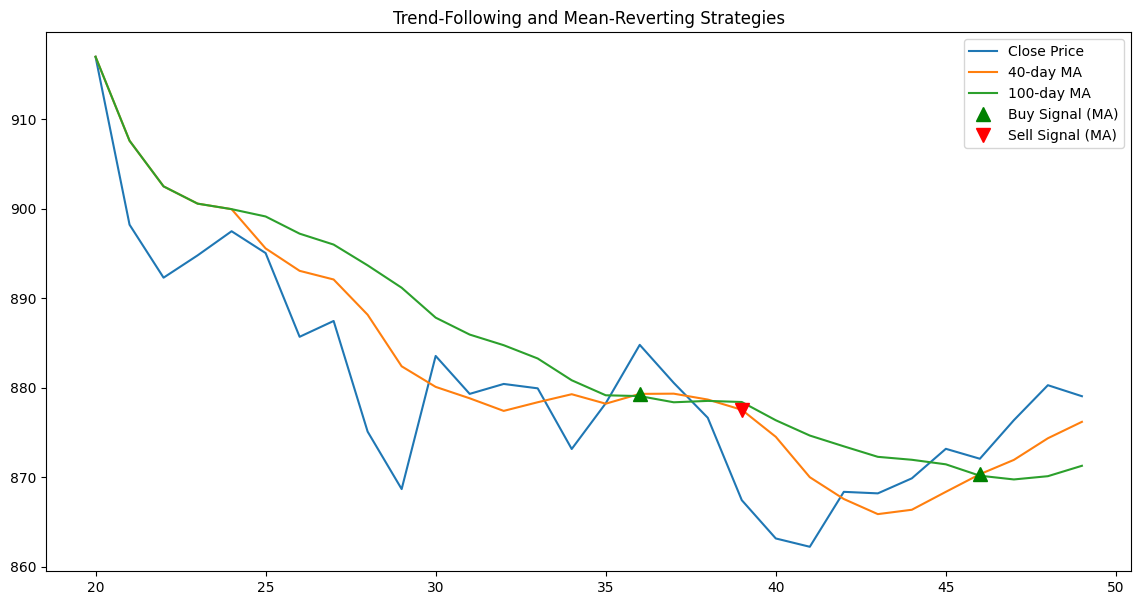

In [ ]:
df1 = pd.read_csv("data_part_5.csv")
df1 = df1.tail(30)

# Generate signals
mac_signals = moving_average_crossover(df1)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df1['VN30'], label='Close Price')
plt.plot(mac_signals['short_mavg'], label='40-day MA')
plt.plot(mac_signals['long_mavg'], label='100-day MA')

# Plot buy and sell signals
plt.plot(mac_signals.loc[mac_signals.positions == 1.0].index,
         mac_signals.short_mavg[mac_signals.positions == 1.0],
         '^', markersize=10, color='g', lw=0, label='Buy Signal (MA)')
plt.plot(mac_signals.loc[mac_signals.positions == -1.0].index,
         mac_signals.short_mavg[mac_signals.positions == -1.0],
         'v', markersize=10, color='r', lw=0, label='Sell Signal (MA)')


plt.title('Trend-Following and Mean-Reverting Strategies')
plt.legend()
plt.show()

In [ ]:
mac_signals.to_csv("result5.csv")

**Change point**

/content/uni2ts/src/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")
Saving the dataset (1/1 shards): 100% 1/1 [00:00<00:00, 162.71 examples/s]
2024-07-15 10:41:36.053646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 10:41:36.053700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 10:41:36.055185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 10:41:36.062739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in perform

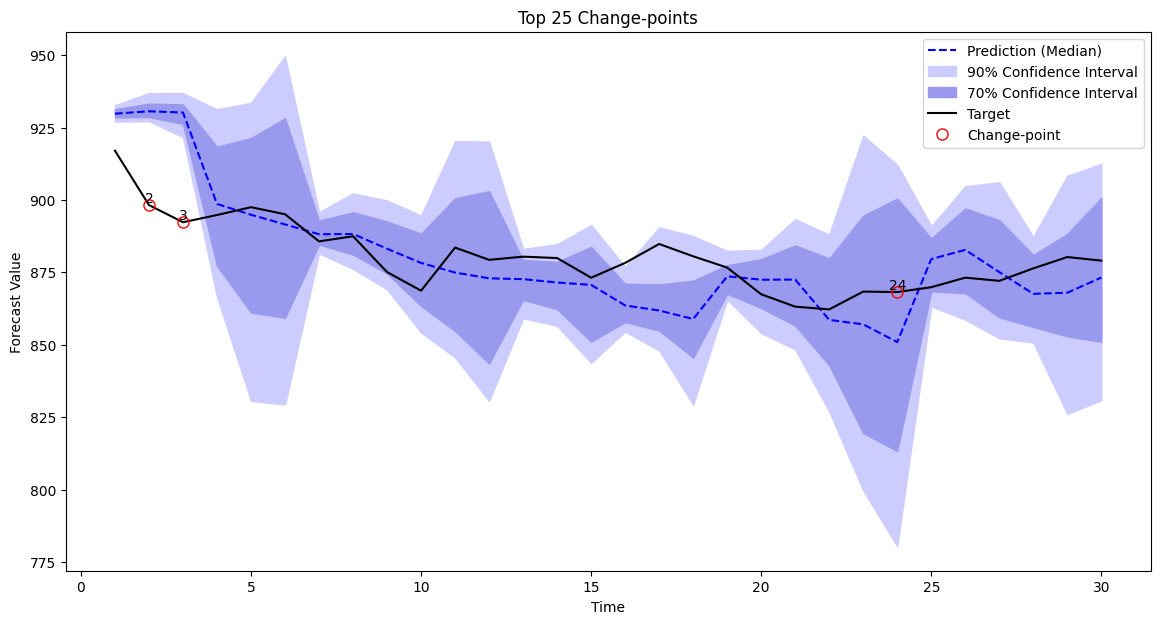

In [ ]:
!python -m uni2ts.data.builder.simple VN30_test data_part_5.csv --dataset_type wide_multivariate

# 1
!python -m cli.eval run_name=base_eval_1407 model=moirai_1.0_R_base model.patch_size=16 model.context_length=200 data=vn30_test



with open("forecast.pkl", "rb") as f:
    forecast = pickle.load(f)

temp1 = None
forecasts = forecast[0]
for i in range(9):
  temp1 = forecast[i+1]
  forecasts = np.hstack((forecasts, temp1))

with open("label.pkl", "rb") as f:
    label = pickle.load(f)

temp2 = None
labels = label[0]
for i in range(9):
  temp2 = label[i+1]
  labels = np.hstack((labels, temp2))

labels = labels.reshape(30, )


mae_forecasts = forecasts
mae_labels = labels

mae_per_day, top_10_days, temp = plot_forecast(mae_forecasts, mae_labels, change_num = 3)

**Sharpe ratio**

In [ ]:
res5 = pd.read_csv("./results/MA_CP5.csv")
res5

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP
0,20,917.00,917.000000,917.000000,0,NaN,NaN,NaN
1,21,898.23,907.615000,907.615000,0,0.0,0.00000,0.00000
2,22,892.31,902.513333,902.513333,0,0.0,0.00000,0.00000
3,23,894.80,900.585000,900.585000,0,0.0,0.00000,0.00000
4,24,897.50,899.968000,899.968000,0,0.0,0.00000,0.00000
5,25,895.06,895.580000,899.150000,0,0.0,0.00000,0.00000
6,26,885.70,893.074000,897.228571,0,0.0,0.00000,0.00000
7,27,887.47,892.106000,896.008750,0,0.0,0.00000,0.00000
8,28,875.10,888.166000,893.685556,0,0.0,0.00000,0.00000
9,29,868.68,882.402000,891.185000,0,0.0,0.00000,0.00000


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res5['MA'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: -3.1207217610968


In [ ]:
# Calculate Sharpe Ratio
risk_free_rate = 0.01
excess_returns = res5['CP'] - risk_free_rate / 252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: -3.1207217610968


In [ ]:
# Calculate cumulative returns
res5['Cumulative MA'] = (1 + res5['MA']).cumprod() - 1
res5['Cumulative CP'] = (1 + res5['CP']).cumprod() - 1
res5

,Unnamed: 0,price,short_mavg,long_mavg,signal,positions,MA,CP,Cumulative MA,Cumulative CP
0,20,917.00,917.000000,917.000000,0,NaN,NaN,NaN,NaN,NaN
1,21,898.23,907.615000,907.615000,0,0.0,0.00000,0.00000,0.00000,0.00000
2,22,892.31,902.513333,902.513333,0,0.0,0.00000,0.00000,0.00000,0.00000
3,23,894.80,900.585000,900.585000,0,0.0,0.00000,0.00000,0.00000,0.00000
4,24,897.50,899.968000,899.968000,0,0.0,0.00000,0.00000,0.00000,0.00000
5,25,895.06,895.580000,899.150000,0,0.0,0.00000,0.00000,0.00000,0.00000
6,26,885.70,893.074000,897.228571,0,0.0,0.00000,0.00000,0.00000,0.00000
7,27,887.47,892.106000,896.008750,0,0.0,0.00000,0.00000,0.00000,0.00000
8,28,875.10,888.166000,893.685556,0,0.0,0.00000,0.00000,0.00000,0.00000
9,29,868.68,882.402000,891.185000,0,0.0,0.00000,0.00000,0.00000,0.00000
